#### Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).





In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats.mstats import winsorize

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GroupKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import catboost as cb
from datetime import timedelta
import datetime as dt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from boostaroota import BoostARoota

import shap
shap.initjs()

In [2]:
# путь расположения выборки
path_train = '/kaggle/input/assignment/assignment_2_train_upd.csv'
path_leaderboard = '/kaggle/input/assignment/assignment_2_test_upd.csv'

In [3]:
# загрузка данных из файла
train = pd.read_csv(path_train)
test = pd.read_csv(path_leaderboard)

#### Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.


In [4]:
train

TransactionID  isFraud  TransactionAmt ProductCD  card1  card2  card3  \
0             2987000        0           68.50         W  13926    0.0  150.0   
1             2987001        0           29.00         W   2755  404.0  150.0   
2             2987002        0           59.00         W   4663  490.0  150.0   
3             2987003        0           50.00         W  18132  567.0  150.0   
4             2987004        0           50.00         H   4497  514.0  150.0   
...               ...      ...             ...       ...    ...    ...    ...   
179995        3166995        0           39.00         W   1877  310.0  150.0   
179996        3166996        0           59.95         W  10075  514.0  150.0   
179997        3166997        0           34.00         W   6053  122.0  150.0   
179998        3166998        0           59.00         W   7726  555.0  150.0   
179999        3166999        0          226.00         W  17480  528.0  150.0   

             card4  card5   card6  ...  D15_mean_card1+card2  \
0         discover  142.0  credit  ...            236.111111   
1       mastercard  102.0  credit  ...            114.397661   
2             visa  166.0   debit  ...            114.579167   
3       mastercard  117.0   debit  ...            179.988989   
4       mastercard  102.0  credit  ...            310.166667   
...            ...    ...     ...  ...                   ...   
179995  mastercard  224.0   debit  ...             84.800000   
179996  mastercard  224.0   debit  ...            204.650000   
179997  mastercard  195.0   debit  ...            132.256410   
179998        visa  226.0   debit  ...            353.600000   
179999        visa  226.0  credit  ...            106.276596   

        D15_std_card1+card2  D15_mean_card1+card2+card3+card5  \
0                216.965947                         22.800000   
1                177.310146                        115.966790   
2                161.160443                        114.579167   
3                185.183067                        179.988989   
4                140.350157                               NaN   
...                     ...                               ...   
179995           179.679576                         84.800000   
179996           206.541754                        208.333333   
179997           164.683927                        132.256410   
179998             8.988882                        353.600000   
179999           140.599843                        106.276596   

        D15_std_card1+card2+card3+card5 D15_mean_card1-5+addr1-2  \
0                             38.180274                15.500000   
1                            170.536981                76.958333   
2                            161.160443                96.072464   
3                            185.183067               203.243478   
4                                   NaN                 5.000000   
...                                 ...                      ...   
179995                       179.679576                84.800000   
179996                       207.906650               250.816667   
179997                       164.683927                33.333333   
179998                         8.988882               148.000000   
179999                       140.599843                84.956522   

        D15_std_card1-5+addr1-2  TransactionAmt_int  TransactionAmt_float  \
0                     21.920310                68.0                  0.50   
1                    126.300359                29.0                  0.00   
2                    147.428180                59.0                  0.00   
3                    165.811698                50.0                  0.00   
4                     16.583124                50.0                  0.00   
...                         ...                 ...                   ...   
179995               179.679576                39.0                  0.00   
179996               209.987045                59.0 

In [5]:
categorical = train.select_dtypes(include = ['object'])

for cat in categorical:
    categorical = pd.concat([categorical, pd.get_dummies(categorical[cat], prefix=cat)], axis=1)

In [6]:
categorical = test.select_dtypes(include = ['object'])

for cat in categorical:
    categorical = pd.concat([categorical, pd.get_dummies(categorical[cat], prefix=cat)], axis=1)

In [7]:
numerical_features = train.select_dtypes(include=[np.number])
train = pd.concat([numerical_features, categorical], axis=1)


In [8]:
numerical_features = test.select_dtypes(include=[np.number])
test = pd.concat([numerical_features, categorical], axis=1)

In [9]:
train = train.drop(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], axis=1)
test = test.drop(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], axis=1)

In [10]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit()
cv.split?

In [11]:
from sklearn.model_selection import GroupKFold
cv = GroupKFold(n_splits=5)

for train_idx, valid_idx in cv.split(train, train["isFraud"], groups=train["dayofyear"]):
    x_train = train.loc[train_idx]
    x_valid = train.loc[valid_idx]
    break

In [12]:
set(x_train["dayofyear"].unique()) & (set(x_valid["dayofyear"].unique()))

set()

In [13]:
y_train = x_train['isFraud']
x_train = x_train.drop(['isFraud'], axis=1)
y_valid = x_valid['isFraud']
x_valid = x_valid.drop(['isFraud'], axis=1)

In [14]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

In [15]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.80386	valid-auc:0.80241
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.89652	valid-auc:0.88699
[200]	train-auc:0.92199	valid-auc:0.90327
[300]	train-auc:0.93632	valid-auc:0.91199
[400]	train-auc:0.94543	valid-auc:0.91716
[500]	train-auc:0.95216	valid-auc:0.92163
[600]	train-auc:0.95725	valid-auc:0.92444
[700]	train-auc:0.96165	valid-auc:0.92698
[800]	train-auc:0.96544	valid-auc:0.92912
[900]	train-auc:0.96893	valid-auc:0.93147
[1000]	train-auc:0.97208	valid-auc:0.93320
[1100]	train-auc:0.97472	valid-auc:0.93479
[1200]	train-auc:0.97709	valid-auc:0.93634
[1300]	train-auc:0.97934	valid-auc:0.93746
[1400]	train-auc:0.98129	valid-auc:0.93826
[1500]	train-auc:0.98320	valid-auc:0.93915
[1600]	train-auc:0.98477	valid-auc:0.93991
[1700]	train-auc:0.98627	valid-auc:0.94043
[1800]	train-auc:0.98765	valid-auc:0.94125
[1900]	train-auc:0.98886	valid-auc:0.94193
[2000]	tr

#### Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

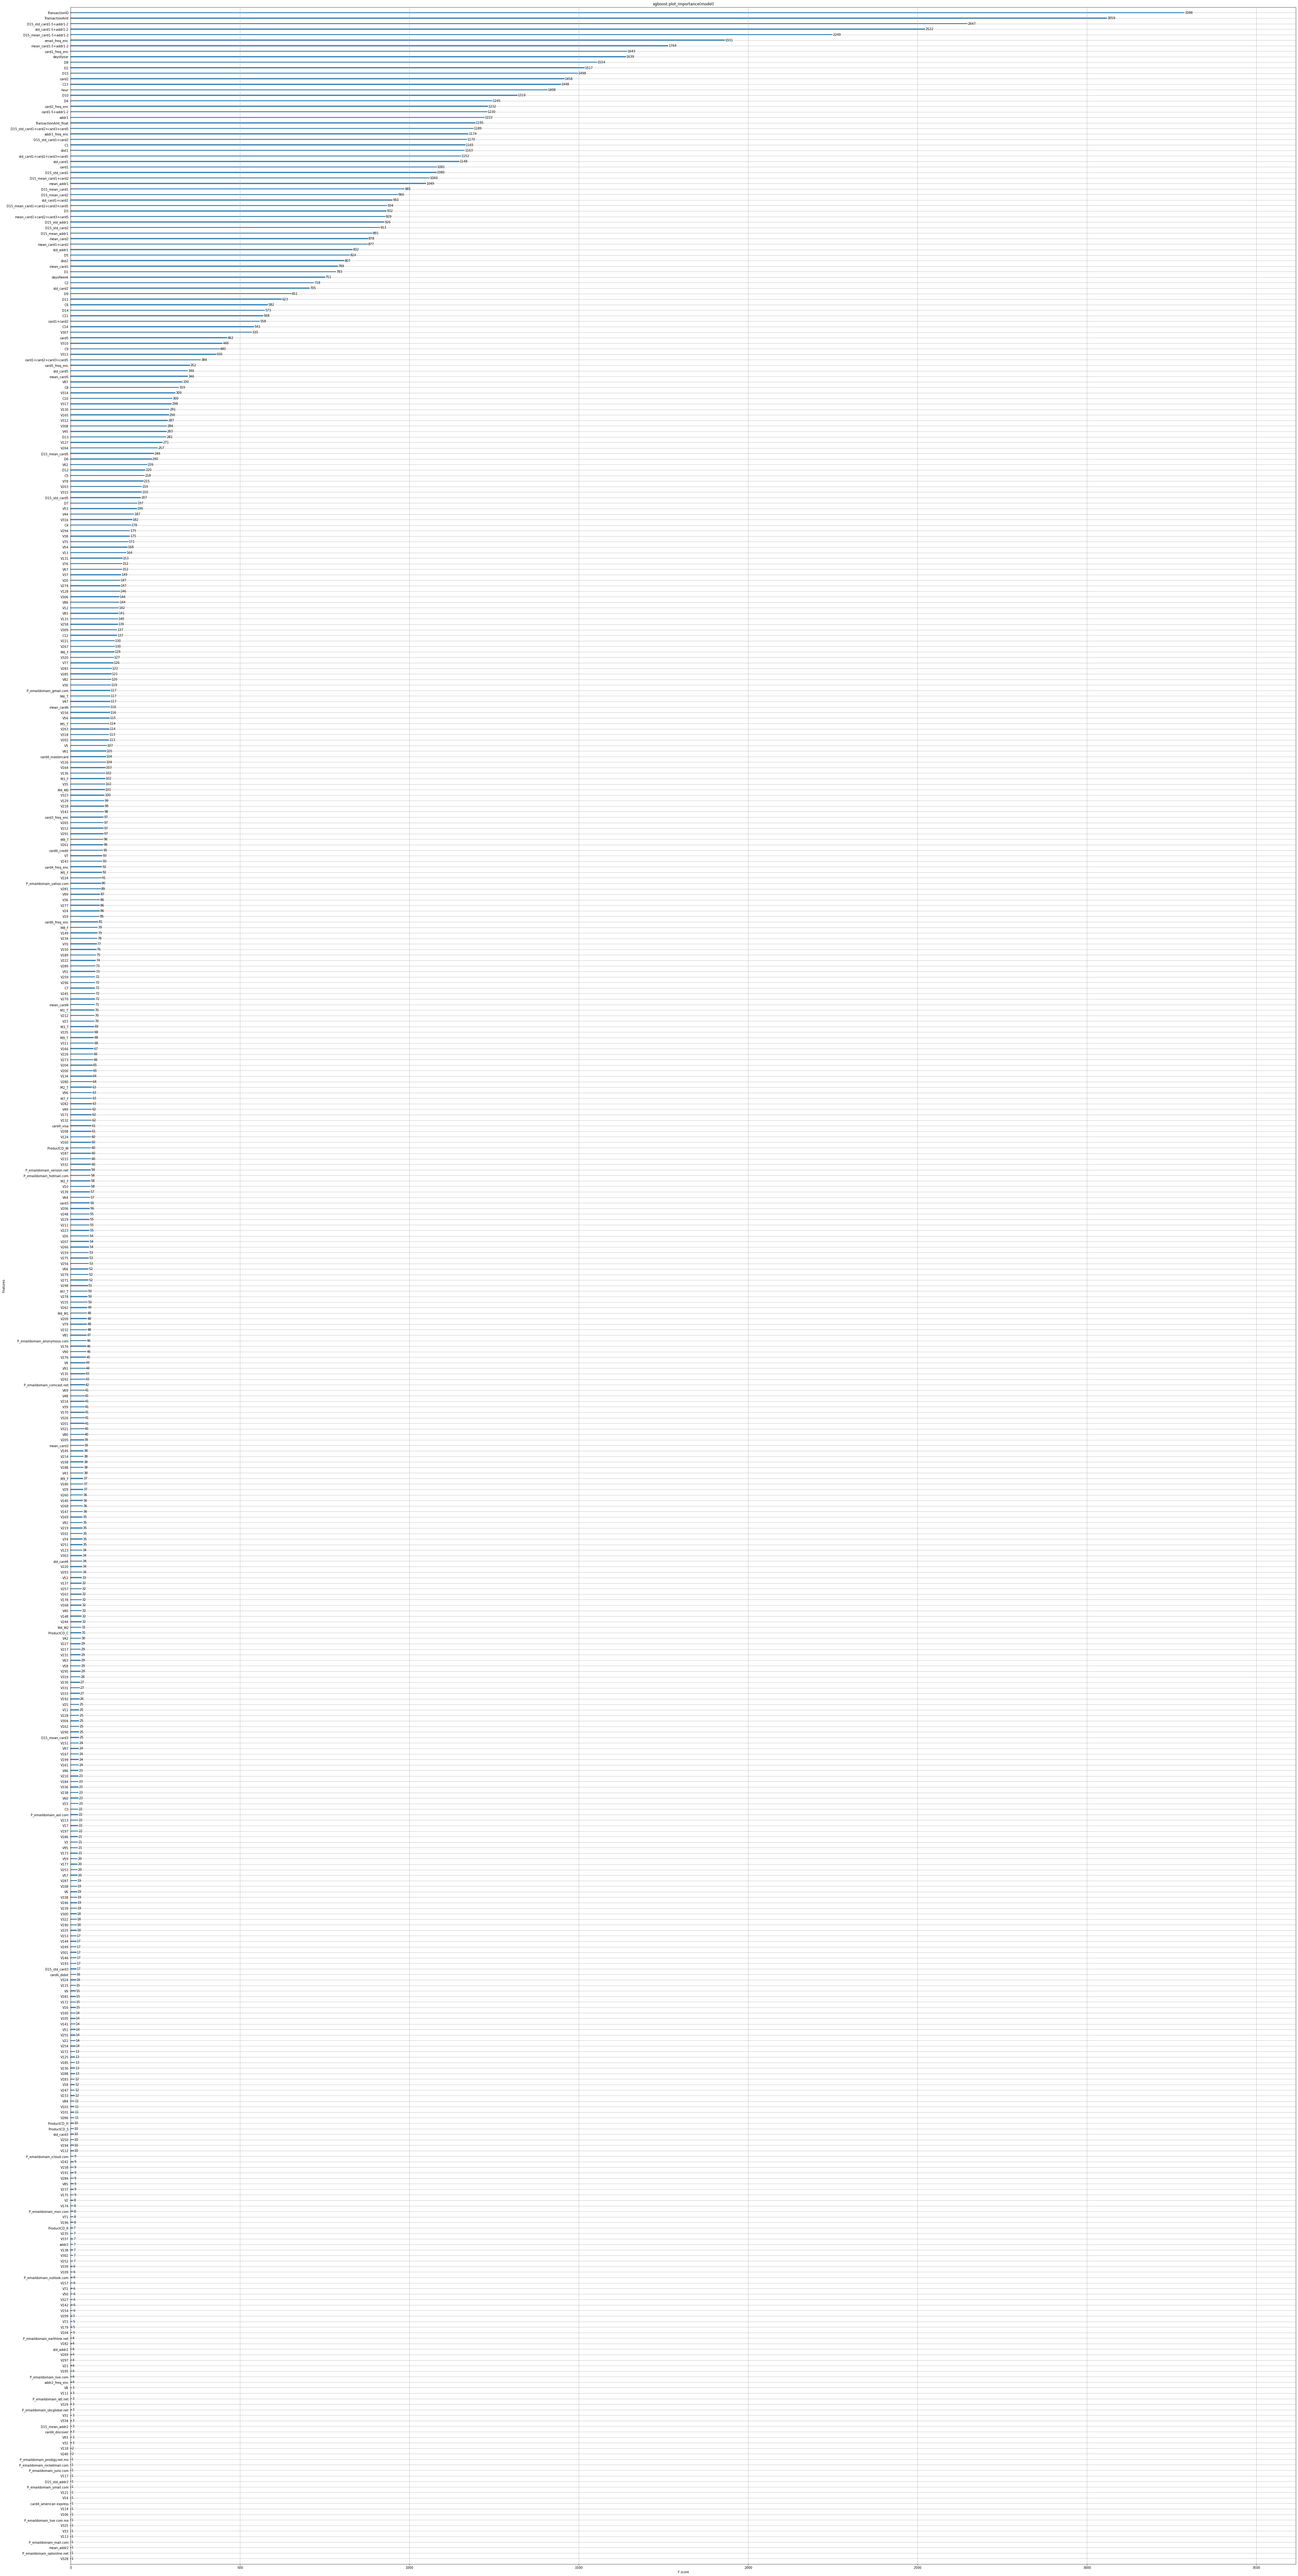

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(70, 150))
xgb.plot_importance(model, ax=ax)
plt.title("xgboost.plot_importance(model)")
plt.show()

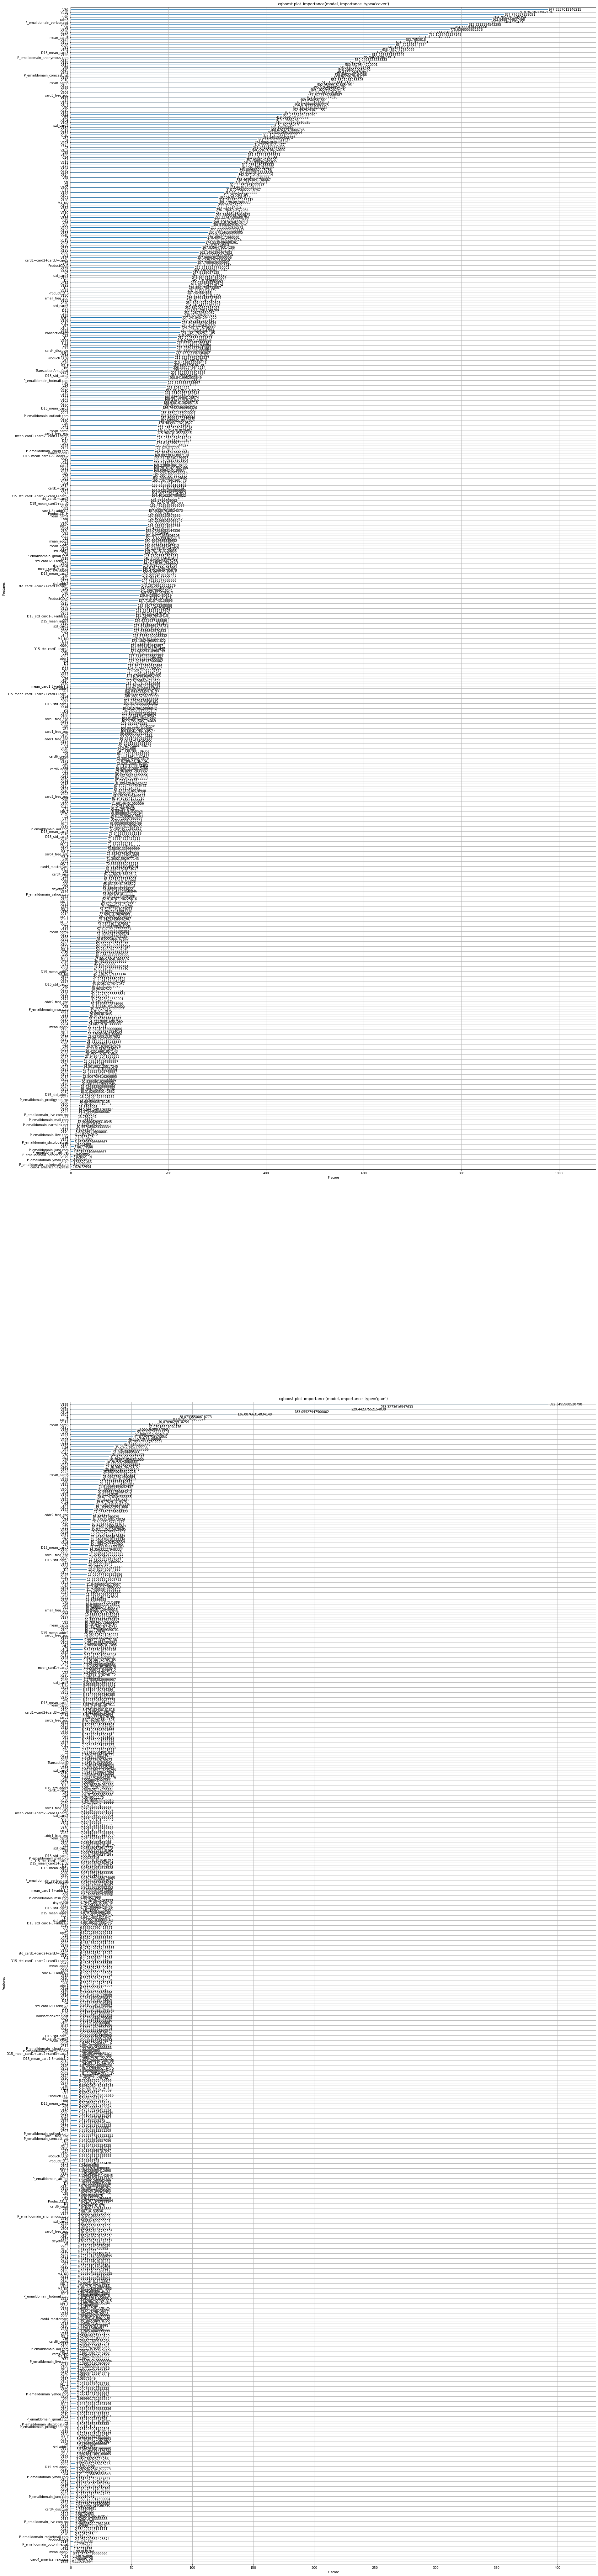

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(30, 150))
xgb.plot_importance(model, ax=ax[0], importance_type="cover")
ax[0].set_title("xgboost.plot_importance(model, importance_type='cover')")

xgb.plot_importance(model, ax=ax[1], importance_type="gain")
ax[1].set_title("xgboost.plot_importance(model, importance_type='gain')")
plt.show()

#### Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

удалим 25 признаков, замыкающие график по Gain

In [18]:
x_train_xgb_importance = x_train.drop(['V89', 'V116', 'V269', 'V106', 'mean_addr2', 'D15_mean_addr2', 'V34', 'V33', 'V158', 'P_emaildomain_ymail.com', 'V31', 'V242', 'V179', 'V95', 'V233','V46', 'V186', 'V257', 'V101', 'V157', 'V252', 'V230', 'V227', 'D15_std_addr2', 'V100'], axis=1)
x_valid_xgb_importance = x_valid.drop(['V89', 'V116', 'V269', 'V106', 'mean_addr2', 'D15_mean_addr2', 'V34', 'V33', 'V158', 'P_emaildomain_ymail.com', 'V31', 'V242', 'V179', 'V95', 'V233','V46', 'V186', 'V257', 'V101', 'V157', 'V252', 'V230', 'V227', 'D15_std_addr2', 'V100'], axis=1)


In [19]:
dtrain = xgb.DMatrix(x_train_xgb_importance, label=y_train)
dvalid = xgb.DMatrix(x_valid_xgb_importance, label=y_valid)

In [20]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.80386	valid-auc:0.80241
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.89655	valid-auc:0.88683
[200]	train-auc:0.92218	valid-auc:0.90336
[300]	train-auc:0.93635	valid-auc:0.91236
[400]	train-auc:0.94512	valid-auc:0.91763
[500]	train-auc:0.95188	valid-auc:0.92229
[600]	train-auc:0.95712	valid-auc:0.92510
[700]	train-auc:0.96160	valid-auc:0.92765
[800]	train-auc:0.96542	valid-auc:0.92991
[900]	train-auc:0.96882	valid-auc:0.93189
[1000]	train-auc:0.97200	valid-auc:0.93363
[1100]	train-auc:0.97469	valid-auc:0.93512
[1200]	train-auc:0.97704	valid-auc:0.93662
[1300]	train-auc:0.97929	valid-auc:0.93790
[1400]	train-auc:0.98130	valid-auc:0.93888
[1500]	train-auc:0.98317	valid-auc:0.93969
[1600]	train-auc:0.98471	valid-auc:0.94047
[1700]	train-auc:0.98623	valid-auc:0.94117
[1800]	train-auc:0.98757	valid-auc:0.94222
[1900]	train-auc:0.98881	valid-auc:0.94284
[2000]	tr

* 1 Модель: [2563]	train-auc:0.99458	valid-auc:0.94473
* 2 Модель: [2825]	train-auc:0.99585	valid-auc:0.94671

Качество заметно лучше, но скорее из-за того, что первая модель рано остановилась

In [21]:
feature_important = model.get_score(importance_type='gain')


In [22]:
import collections
feature_important = sorted(feature_important.items(), key=lambda kv: kv[1])
feature_important = collections.OrderedDict(feature_important)

In [23]:
feature_important

OrderedDict([('P_emaildomain_windstream.net', 0.243567526),
             ('P_emaildomain_cfl.rr.com', 1.75631237),
             ('P_emaildomain_prodigy.net.mx', 1.76480639),
             ('V110', 1.85910177),
             ('V98', 1.96769285),
             ('V117', 1.9773066),
             ('P_emaildomain_sbcglobal.net', 2.2391349571666668),
             ('V121', 2.43425465),
             ('V111', 2.7791303),
             ('card4_discover', 2.7854793873333334),
             ('V329', 2.84944546225),
             ('P_emaildomain_juno.com', 2.88982677),
             ('P_emaildomain_att.net', 2.8910675033333333),
             ('V217', 2.9045472228049998),
             ('V263', 2.9372179217745558),
             ('V177', 2.9398770570076915),
             ('V292', 3.017761726591836),
             ('V195', 3.0587514045),
             ('V228', 3.0895054766100003),
             ('V250', 3.10461420425),
             ('V287', 3.1179667214999998),
             ('V231', 3.14749542528125),
           

In [24]:
feature_important.keys()

odict_keys(['P_emaildomain_windstream.net', 'P_emaildomain_cfl.rr.com', 'P_emaildomain_prodigy.net.mx', 'V110', 'V98', 'V117', 'P_emaildomain_sbcglobal.net', 'V121', 'V111', 'card4_discover', 'V329', 'P_emaildomain_juno.com', 'P_emaildomain_att.net', 'V217', 'V263', 'V177', 'V292', 'V195', 'V228', 'V250', 'V287', 'V231', 'V168', 'V204', 'V126', 'V276', 'V213', 'V236', 'V8', 'V219', 'V273', 'ProductCD_R', 'V17', 'V214', 'V253', 'V337', 'M3_T', 'V260', 'V328', 'V254', 'P_emaildomain_aim.com', 'C3', 'V274', 'M7_T', 'V202', 'V304', 'V290', 'M3_F', 'M8_F', 'V232', 'P_emaildomain_yahoo.com', 'V144', 'P_emaildomain_gmail.com', 'V167', 'V178', 'V176', 'M1_T', 'card6_debit', 'V159', 'card6_credit', 'V104', 'V150', 'V319', 'V321', 'V128', 'M8_T', 'M4_M2', 'V229', 'V265', 'V85', 'V125', 'V211', 'V280', 'V221', 'V218', 'card4_visa', 'card4_mastercard', 'V216', 'V151', 'M5_T', 'P_emaildomain_icloud.com', 'V2', 'V97', 'P_emaildomain_hotmail.com', 'M9_F', 'ProductCD_S', 'V18', 'V81', 'ProductCD_C', '

Уберем все, до значения gain 5.00

In [25]:
x_train_xgb_importance2 = x_train.drop(['P_emaildomain_sbcglobal.net', 'V226', 'V235', 'V98', 'V228', 'V334', 'addr2', 'V219', 'V117', 'V287', 'V232', 'V236', 'V214', 'V85', 'V168', 'V84', 'V191', 'V8', 'V202', 'V280', 'V273', 'V213', 'V18', 'V319', 'V167', 'V263', 'P_emaildomain_optonline.net', 'std_addr2', 'V253', 'V204', 'V292', 'V276', 'V132', 'V297', 'V126', 'V321', 'M1_T', 'V231', 'V48', 'P_emaildomain_me.com', 'V254', 'V260', 'V177', 'V3', 'V274', 'V178', 'V25', 'V176', 'V211', 'V217', 'V171', 'V216', 'V93', 'V264', 'V103', 'M8_T', 'V40', 'V278', 'V290', 'C3', 'D7', 'V17', 'P_emaildomain_yahoo.com.mx', 'V195', 'V6', 'V238', 'V272', 'V330', 'V109', 'V174', 'V108', 'V151', 'V221', 'V128', 'V218', 'V265', 'V127', 'dayofweek', 'V205', 'M9_F', 'V229', 'V115', 'V166', 'V125', 'P_emaildomain_aol.com', 'V329', 'V299', 'P_emaildomain_comcast.net', 'V220', 'card4_freq_enc', 'D9', 'card5_freq_enc', 'V300', 'V277', 'V72', 'std_card3', 'V135', 'V234', 'V318', 'V37', 'V29', 'V212', 'M7_T', 'V81', 'V222', 'V56', 'V104', 'V170', 'V4', 'V203'], axis=1)
x_valid_xgb_importance2 = x_valid.drop(['P_emaildomain_sbcglobal.net', 'V226', 'V235', 'V98', 'V228', 'V334', 'addr2', 'V219', 'V117', 'V287', 'V232', 'V236', 'V214', 'V85', 'V168', 'V84', 'V191', 'V8', 'V202', 'V280', 'V273', 'V213', 'V18', 'V319', 'V167', 'V263', 'P_emaildomain_optonline.net', 'std_addr2', 'V253', 'V204', 'V292', 'V276', 'V132', 'V297', 'V126', 'V321', 'M1_T', 'V231', 'V48', 'P_emaildomain_me.com', 'V254', 'V260', 'V177', 'V3', 'V274', 'V178', 'V25', 'V176', 'V211', 'V217', 'V171', 'V216', 'V93', 'V264', 'V103', 'M8_T', 'V40', 'V278', 'V290', 'C3', 'D7', 'V17', 'P_emaildomain_yahoo.com.mx', 'V195', 'V6', 'V238', 'V272', 'V330', 'V109', 'V174', 'V108', 'V151', 'V221', 'V128', 'V218', 'V265', 'V127', 'dayofweek', 'V205', 'M9_F', 'V229', 'V115', 'V166', 'V125', 'P_emaildomain_aol.com', 'V329', 'V299', 'P_emaildomain_comcast.net', 'V220', 'card4_freq_enc', 'D9', 'card5_freq_enc', 'V300', 'V277', 'V72', 'std_card3', 'V135', 'V234', 'V318', 'V37', 'V29', 'V212', 'M7_T', 'V81', 'V222', 'V56', 'V104', 'V170', 'V4', 'V203'], axis=1)


In [26]:
deleted = ['P_emaildomain_sbcglobal.net', 'V226', 'V235', 'V98', 'V228', 'V334', 'addr2', 'V219', 'V117', 'V287', 'V232', 'V236', 'V214', 'V85', 'V168', 'V84', 'V191', 'V8', 'V202', 'V280', 'V273', 'V213', 'V18', 'V319', 'V167', 'V263', 'P_emaildomain_optonline.net', 'std_addr2', 'V253', 'V204', 'V292', 'V276', 'V132', 'V297', 'V126', 'V321', 'M1_T', 'V231', 'V48', 'P_emaildomain_me.com', 'V254', 'V260', 'V177', 'V3', 'V274', 'V178', 'V25', 'V176', 'V211', 'V217', 'V171', 'V216', 'V93', 'V264', 'V103', 'M8_T', 'V40', 'V278', 'V290', 'C3', 'D7', 'V17', 'P_emaildomain_yahoo.com.mx', 'V195', 'V6', 'V238', 'V272', 'V330', 'V109', 'V174', 'V108', 'V151', 'V221', 'V128', 'V218', 'V265', 'V127', 'dayofweek', 'V205', 'M9_F', 'V229', 'V115', 'V166', 'V125', 'P_emaildomain_aol.com', 'V329', 'V299', 'P_emaildomain_comcast.net', 'V220', 'card4_freq_enc', 'D9', 'card5_freq_enc', 'V300', 'V277', 'V72', 'std_card3', 'V135', 'V234', 'V318', 'V37', 'V29', 'V212', 'M7_T', 'V81', 'V222', 'V56', 'V104', 'V170', 'V4', 'V203']
len(deleted)
#Убрали 110 признаков

110

In [27]:
dtrain = xgb.DMatrix(x_train_xgb_importance2, label=y_train)
dvalid = xgb.DMatrix(x_valid_xgb_importance2, label=y_valid)

In [28]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.80386	valid-auc:0.80241
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.89675	valid-auc:0.88711
[200]	train-auc:0.92222	valid-auc:0.90336
[300]	train-auc:0.93628	valid-auc:0.91227
[400]	train-auc:0.94512	valid-auc:0.91775
[500]	train-auc:0.95208	valid-auc:0.92234
[600]	train-auc:0.95719	valid-auc:0.92527
[700]	train-auc:0.96150	valid-auc:0.92768
[800]	train-auc:0.96530	valid-auc:0.93007
[900]	train-auc:0.96877	valid-auc:0.93220
[1000]	train-auc:0.97197	valid-auc:0.93367
[1100]	train-auc:0.97481	valid-auc:0.93510
[1200]	train-auc:0.97717	valid-auc:0.93654
[1300]	train-auc:0.97926	valid-auc:0.93768
[1400]	train-auc:0.98131	valid-auc:0.93877
[1500]	train-auc:0.98320	valid-auc:0.93967
[1600]	train-auc:0.98474	valid-auc:0.94037
[1700]	train-auc:0.98626	valid-auc:0.94109
[1800]	train-auc:0.98769	valid-auc:0.94186
[1900]	train-auc:0.98886	valid-auc:0.94252
[2000]	tr

* 1 Модель: [2563]	train-auc:0.99458	valid-auc:0.94473
* 2 Модель: [2825]	train-auc:0.99585	valid-auc:0.94671
* 2.1 Модель: [2776]	train-auc:0.99574	valid-auc:0.94598

результат уступает предыдущей модели, также остановилась рано. 

#### Задание 3: использовать permutation importance, выполнить задание 1 и 2.


In [29]:
from copy import deepcopy

xgb_params = deepcopy(params)
xgb_params["n_estimators"] = 100

model = xgb.XGBClassifier(**xgb_params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.02800732381423131, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.01, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_score = model.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_score)

print(f"Valid score = {round(score, 4)}")

Valid score = 0.8864


In [31]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(
    model, x_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [32]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [33]:
importance_scores

features  importance-mean  importance-std
0              V317         0.010308        0.000894
1               C14         0.007976        0.000392
2               C13         0.007056        0.000517
3                D2         0.006966        0.001174
4    TransactionAmt         0.004563        0.001011
..              ...              ...             ...
530            V246        -0.000108        0.000085
531            V175        -0.000118        0.000150
532            V243        -0.000162        0.000719
533            V295        -0.000255        0.000094
534       std_card2        -0.000272        0.000342

[535 rows x 3 columns]

In [34]:
decrease_scores

features  importance-mean  importance-std
0                        month         0.000000        0.000000
1                         week         0.000000        0.000000
2                        M4_M2         0.000000        0.000000
3        P_emaildomain_aim.com         0.000000        0.000000
4    P_emaildomain_charter.net         0.000000        0.000000
..                         ...              ...             ...
272                       V246        -0.000108        0.000085
273                       V175        -0.000118        0.000150
274                       V243        -0.000162        0.000719
275                       V295        -0.000255        0.000094
276                  std_card2        -0.000272        0.000342

[277 rows x 3 columns]

In [35]:
decrease_scores_list = decrease_scores['features'].tolist()

In [36]:
decrease_scores_list
len(decrease_scores_list)
#убираем 277 отрицательных признаков

277

In [37]:
x_train_perm_importance = x_train.drop(decrease_scores_list, axis=1)
x_valid_perm_importance = x_valid.drop(decrease_scores_list, axis=1)


In [38]:
dtrain = xgb.DMatrix(x_train_perm_importance, label=y_train)
dvalid = xgb.DMatrix(x_valid_perm_importance, label=y_valid)

In [39]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.80722	valid-auc:0.80991
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.89679	valid-auc:0.88841
[200]	train-auc:0.92268	valid-auc:0.90452
[300]	train-auc:0.93675	valid-auc:0.91348
[400]	train-auc:0.94576	valid-auc:0.91865
[500]	train-auc:0.95238	valid-auc:0.92300
[600]	train-auc:0.95747	valid-auc:0.92593
[700]	train-auc:0.96210	valid-auc:0.92879
[800]	train-auc:0.96581	valid-auc:0.93078
[900]	train-auc:0.96911	valid-auc:0.93300
[1000]	train-auc:0.97228	valid-auc:0.93452
[1100]	train-auc:0.97506	valid-auc:0.93618
[1200]	train-auc:0.97741	valid-auc:0.93754
[1300]	train-auc:0.97959	valid-auc:0.93872
[1400]	train-auc:0.98164	valid-auc:0.93975
[1500]	train-auc:0.98347	valid-auc:0.94071
[1600]	train-auc:0.98503	valid-auc:0.94146
[1700]	train-auc:0.98650	valid-auc:0.94211
[1800]	train-auc:0.98789	valid-auc:0.94276
[1900]	train-auc:0.98913	valid-auc:0.94325
[2000]	tr

* 1 Модель: [2563]	train-auc:0.99458	valid-auc:0.94473
* 2 Модель: [2825]	train-auc:0.99585	valid-auc:0.94671
* 2.1 Модель: [2776]	train-auc:0.99574	valid-auc:0.94598
* 3 модель: [2796]	train-auc:0.99582	valid-auc:0.94630

результат чуть хуже второй

#### Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.


In [40]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}

dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

In [41]:
br = BoostARoota(metric='auc')
br.fit(x_train, y_train)

[10:12:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[10:13:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[10:16:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to som

Round:  3  iteration:  1
[10:43:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  3  iteration:  2
[10:43:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  3  iteration:  3
[10:43:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may n

In [42]:
br.keep_vars_

0                 TransactionID
1                TransactionAmt
2                         card1
3                         card2
4                         card3
                 ...           
263    D15_mean_card1-5+addr1-2
264     D15_std_card1-5+addr1-2
265        TransactionAmt_float
266              email_freq_enc
267       P_emaildomain_aol.com
Name: feature, Length: 253, dtype: object

In [43]:
x_train_br = br.transform(x_train)
x_valid_br = br.transform(x_valid)

dtrain_br = xgb.DMatrix(x_train_br, label=y_train)
dvalid_br = xgb.DMatrix(x_valid_br, label=y_valid)

In [44]:
model_br = xgb.train(
    params,
    dtrain_br,
    num_boost_round=5000,
    evals=[(dtrain_br, "train"), (dvalid_br, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.80302	valid-auc:0.79953
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.89587	valid-auc:0.88652
[200]	train-auc:0.92172	valid-auc:0.90226
[300]	train-auc:0.93693	valid-auc:0.91231
[400]	train-auc:0.94584	valid-auc:0.91777
[500]	train-auc:0.95230	valid-auc:0.92189
[600]	train-auc:0.95751	valid-auc:0.92482
[700]	train-auc:0.96223	valid-auc:0.92730
[800]	train-auc:0.96606	valid-auc:0.92959
[900]	train-auc:0.96924	valid-auc:0.93155
[1000]	train-auc:0.97254	valid-auc:0.93344
[1100]	train-auc:0.97522	valid-auc:0.93497
[1200]	train-auc:0.97760	valid-auc:0.93624
[1300]	train-auc:0.97987	valid-auc:0.93753
[1400]	train-auc:0.98196	valid-auc:0.93860
[1500]	train-auc:0.98377	valid-auc:0.93945
[1600]	train-auc:0.98533	valid-auc:0.94034
[1700]	train-auc:0.98679	valid-auc:0.94113
[1800]	train-auc:0.98818	valid-auc:0.94196
[1900]	train-auc:0.98935	valid-auc:0.94254
[2000]	tr

* 1 Модель: [2563]	train-auc:0.99458	valid-auc:0.94473
* 2 Модель: [2825]	train-auc:0.99585	valid-auc:0.94671
* 2.1 Модель: [2776]	train-auc:0.99574	valid-auc:0.94598
* 3 модель: [2796]	train-auc:0.99582	valid-auc:0.94630
* 4 модель: [2901]	train-auc:0.99634	valid-auc:0.94672

Результат практически аналогичен второй, где мы убрали 25 плохих признаков.

#### Задание 5: использовать shap, выполнить задание 1 и 2.


In [46]:
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.02800732381423131, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.01, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)

In [50]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid.iloc[0,:], link="logit"
)

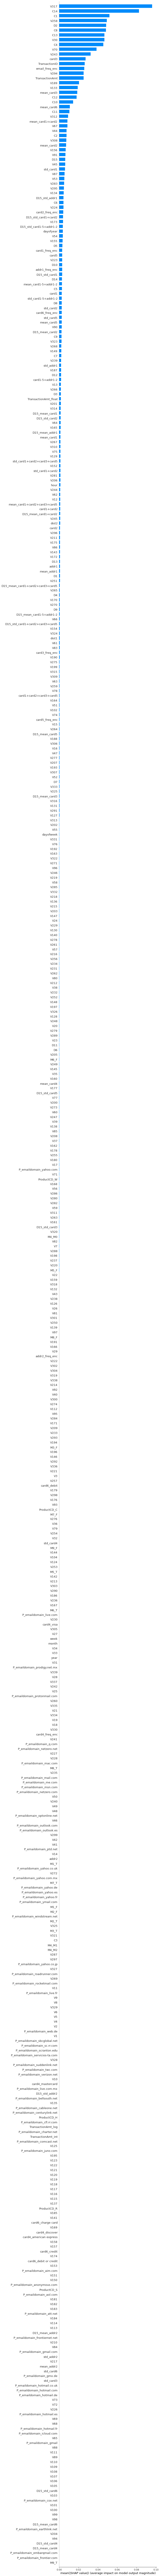

In [51]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [52]:
pd.DataFrame({
    'name': x_valid.columns,
    'importance': np.mean(np.abs(shap_values), axis=0)
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

name  importance
0    V317    0.096134
1     C14    0.082570
2      C1    0.051906
3    V258    0.049343
4      D2    0.048512
..    ...         ...
530  V335    0.000000
531  V337    0.000000
532  V339    0.000000
533  year    0.000000
534  M9_T    0.000000

[535 rows x 2 columns]

создадим список признаков, которые имеют нулевую важность, после чего удалим их

In [53]:
to_drop = list(pd.DataFrame({'name': x_valid.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(200)['name'])
to_drop

['M6_T',
 'P_emaildomain_live.com',
 'V230',
 'card4_visa',
 'ProductCD_H',
 'card6_charge card',
 'D15_std_addr2',
 'D15_mean_addr2',
 'card4_mastercard',
 'M3_T',
 'card6_credit',
 'P_emaildomain_yahoo.de',
 'V5',
 'card6_debit or credit',
 'P_emaildomain_aim.com',
 'P_emaildomain_anonymous.com',
 'P_emaildomain_aol.com',
 'V6',
 'P_emaildomain_yahoo.com.mx',
 'V4',
 'card4_discover',
 'V2',
 'C3',
 'P_emaildomain_web.de',
 'ProductCD_R',
 'addr2',
 'P_emaildomain_verizon.net',
 'ProductCD_S',
 'TransactionAmt_log',
 'TransactionAmt_int',
 'P_emaildomain_yahoo.co.uk',
 'P_emaildomain_windstream.net',
 'card4_american express',
 'P_emaildomain_twc.com',
 'P_emaildomain_yahoo.co.jp',
 'M8_T',
 'V1',
 'P_emaildomain_att.net',
 'P_emaildomain_yahoo.es',
 'P_emaildomain_bellsouth.net',
 'P_emaildomain_hotmail.fr',
 'P_emaildomain_juno.com',
 'P_emaildomain_rocketmail.com',
 'M1_F',
 'P_emaildomain_live.com.mx',
 'P_emaildomain_ymail.com',
 'M4_M2',
 'M7_T',
 'P_emaildomain_roadrunner.com'

In [54]:
x_train_shap = x_train.drop(to_drop, axis=1)
x_valid_shap = x_valid.drop(to_drop, axis=1)

In [55]:
dtrain = xgb.DMatrix(x_train_shap, label=y_train)
dvalid = xgb.DMatrix(x_valid_shap, label=y_valid)

In [56]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.80386	valid-auc:0.80241
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.89652	valid-auc:0.88699
[200]	train-auc:0.92228	valid-auc:0.90365
[300]	train-auc:0.93662	valid-auc:0.91260
[400]	train-auc:0.94574	valid-auc:0.91809
[500]	train-auc:0.95254	valid-auc:0.92266
[600]	train-auc:0.95753	valid-auc:0.92582
[700]	train-auc:0.96193	valid-auc:0.92846
[800]	train-auc:0.96564	valid-auc:0.93055
[900]	train-auc:0.96907	valid-auc:0.93271
[1000]	train-auc:0.97211	valid-auc:0.93424
[1100]	train-auc:0.97479	valid-auc:0.93558
[1200]	train-auc:0.97723	valid-auc:0.93724
[1300]	train-auc:0.97948	valid-auc:0.93853
[1400]	train-auc:0.98161	valid-auc:0.93953
[1500]	train-auc:0.98347	valid-auc:0.94049
[1600]	train-auc:0.98508	valid-auc:0.94121
[1700]	train-auc:0.98657	valid-auc:0.94187
[1800]	train-auc:0.98801	valid-auc:0.94254
[1900]	train-auc:0.98921	valid-auc:0.94324
[2000]	tr

* 1 Модель: [2563]	train-auc:0.99458	valid-auc:0.94473
* 2 Модель: [2825]	train-auc:0.99585	valid-auc:0.94671
* 2.1 Модель: [2776]	train-auc:0.99574	valid-auc:0.94598
* 3 модель: [2796]	train-auc:0.99582	valid-auc:0.94630
* 4 модель: [2901]	train-auc:0.99634	valid-auc:0.94672
* 5 модель: [2717]	train-auc:0.99548	valid-auc:0.94645

Модель шла с заметным опережение предыдущей, но в итоге затормозила и показала качество хуже.

#### Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [61]:
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.02800732381423131, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.01, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
x_valid_, y_valid_ = x_valid.sample(5000), y_valid.sample(5000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_, y_valid_)

In [63]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid_.iloc[0,:], link="logit"
)

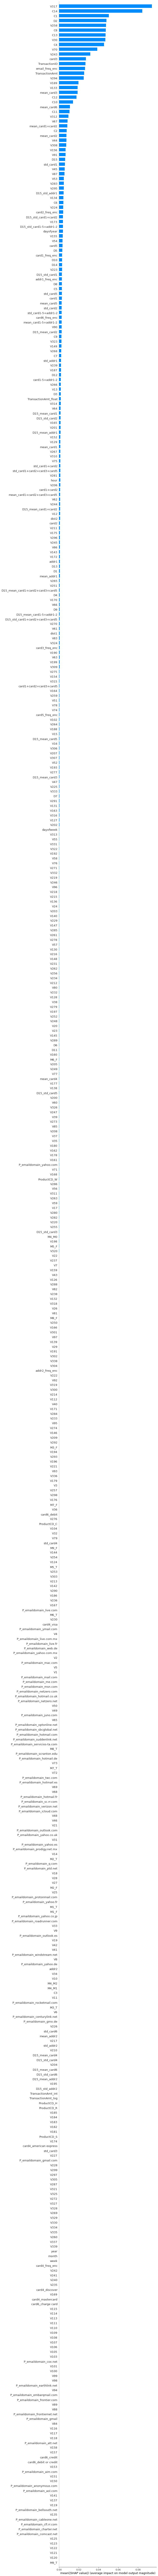

In [64]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=x_valid_.shape[1])


Топ признаков по важности от сокращения выборки не изменился.

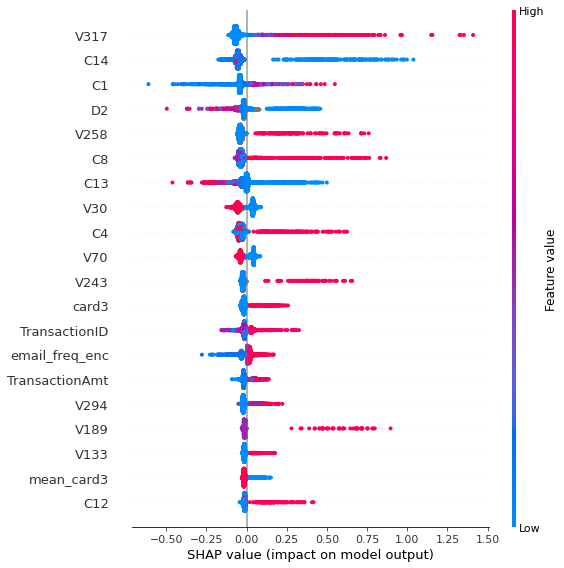

In [65]:
shap.summary_plot(shap_values, x_valid_)

In [68]:
?shap.dependence_plot

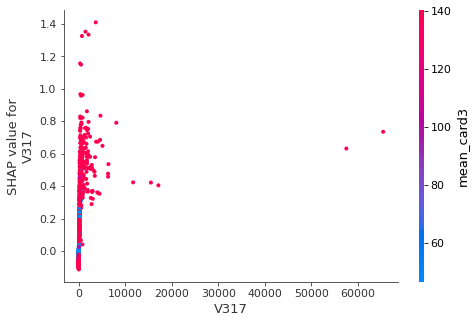

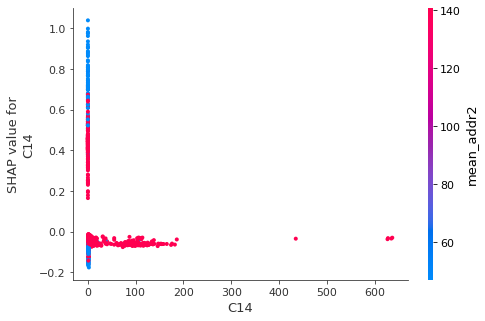

ValueError: There are 868 color bins including extensions, but ncolors = 255; ncolors must equal or exceed the number of bins

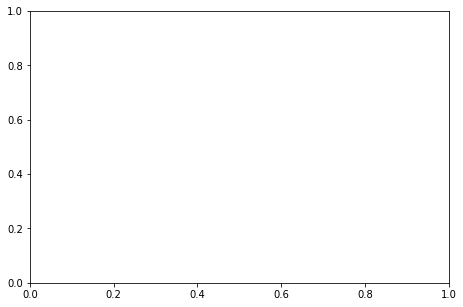

In [67]:
dependence_features = ['V317', 'C14', 'C1', 'D2', 'V258', 'C8', 'C13', 'V30', 'C4', 'V70'
]
for name in dependence_features:
    shap.dependence_plot(name, shap_values, x_valid_, display_features=x_valid_)